# Inference and Validation 

- model 1 : CE model on street view  
- model 2 : CE model on top view

- 1. Visualize to compare two models output
- 2. Compare model confidence about the result 
- Ensemble ( 15 18 )  
 
softmax 이후의 확률값을 비교해서 더 큰 쪽을 활용

In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- all infos
inference_dict ={
    'models':[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_5.yaml', 'finetune_8.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('./configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    inference_dict['cfgs'].append(cfg)
    print("Model run version : ", cfg.RUN_VERSION)

Model run version :  15
Model run version :  18


In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [5]:
ckpt_paths = [
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/15_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.65_epoch_8.pth",
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/18_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.7226_epoch_5.pth" ]

for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i]))

In [6]:
train_set = map_dataset.Map_Dataset_v7(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid") 
valid_set = map_dataset.Map_Dataset_v7(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

idx :  205


5 < Label > 
5 < 1 Model Prediction > 
tensor([[4.6738e-04, 8.8626e-05, 1.4923e-03, 1.9130e-04, 5.3207e-03, 9.2801e-01,
         6.4432e-02]], device='cuda:3', grad_fn=<SoftmaxBackward0>)


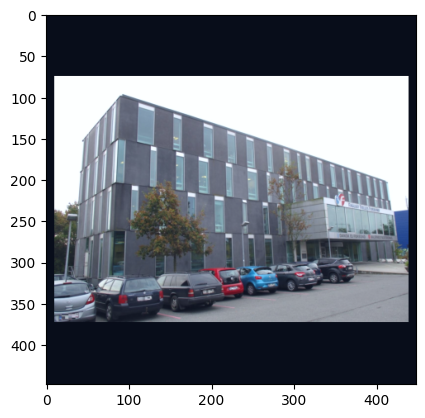

In [7]:
'''
#--- Single image for Visualization 
# A model : Cross-entropy loss with Street Voew 
# B model : Cross-entropy loss with Top Voew

'''
idx_ = random.randint(0,999)
print("idx : ", idx_)

dataset = valid_set

street_view = dataset.__getitem__(idx_)[0]
img_torch = street_view 
#RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"


def infer_model(img_torch,model,loss_type):
    
    img_torch = img_torch.to(device)
    
    model = model.eval()
    model = model.to(device)
    img_torch = img_torch.unsqueeze(0)
    preds = model(img_torch)
    
    if loss_type == "CE":
        preds_ = preds.softmax(-1).argmax(-1)
    elif loss_type == "MSE" or loss_type == "MAE":
        preds_ = preds
    print(dataset.__getitem__(idx_)[-1], "< Label > ")
    print(preds_.item(), f"< {i} Model Prediction > ")
    #print(preds)
    print(preds.softmax(-1))
    
    img_torch = img_torch.squeeze(0)
    img = img_torch.clone() 
    
    # denormal
    img = ((img) * 0.22) + 0.5
    # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    #-----
            
    img = img.permute(1,2,0).cpu()
    img = np.asarray(img)   
    plt.imshow(img)
        
            
#-- 
infer_model(img_torch,inference_dict['models'][0],"CE")

In [8]:
5.4082e-01

0.54082

5 < Label > 
5 < 1 Model Prediction > 
tensor([[0.0062, 0.0013, 0.0039, 0.0225, 0.0507, 0.7522, 0.1632]],
       device='cuda:3', grad_fn=<SoftmaxBackward0>)


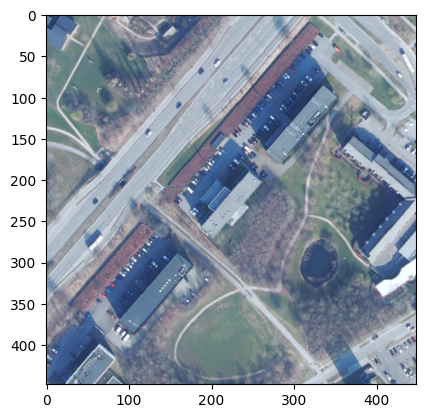

In [9]:
top_view = dataset.__getitem__(idx_)[1]
img_torch = top_view 

infer_model(img_torch,inference_dict['models'][1],"CE")

In [10]:
9.4371e-01

0.94371

# Compare model confidence about the result and Ensemble !!  

In [11]:
'''
gather predictions of CE model 1

'''

model = inference_dict['models'][0]


from tqdm import tqdm 

batch_size = 8
TrainLoader = DataLoader(train_set,batch_size)
ValidLoader = DataLoader(valid_set,batch_size,shuffle=False)

device = "cuda:3"

#-- Loader train/valid
Loader = ValidLoader
#--
labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[0].to(device)
    lables = batch[-1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
inference_dict['labels'].append(labels_)


100%|██████████| 386/386 [01:53<00:00,  3.40it/s]


In [12]:
inference_dict['predictions'][0].__len__()

3085

In [13]:
'''
gather predictions of CE model 2 

'''

model = inference_dict['models'][1]

#--
labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[1].to(device)
    lables = batch[-1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
inference_dict['labels'].append(labels_)



100%|██████████| 386/386 [01:50<00:00,  3.50it/s]


In [14]:
inference_dict['predictions'][1].__len__()

3085

In [15]:
ce_model_confidence_0 = [max(i.softmax(-1)) for i in inference_dict['predictions'][0]]

In [16]:
ce_model_confidence_1 = [max(i.softmax(-1)) for i in inference_dict['predictions'][1]]

In [17]:
ce_model_confidence_0

[tensor(0.9994),
 tensor(0.9998),
 tensor(0.9552),
 tensor(0.6665),
 tensor(0.7462),
 tensor(0.9893),
 tensor(0.8824),
 tensor(0.9638),
 tensor(0.7716),
 tensor(0.9890),
 tensor(0.9999),
 tensor(0.9991),
 tensor(0.9863),
 tensor(0.5812),
 tensor(0.7945),
 tensor(0.8357),
 tensor(0.9434),
 tensor(0.9967),
 tensor(0.9997),
 tensor(0.9996),
 tensor(0.9845),
 tensor(0.5662),
 tensor(0.7945),
 tensor(0.9906),
 tensor(0.5766),
 tensor(0.9986),
 tensor(0.9998),
 tensor(0.9799),
 tensor(0.9969),
 tensor(0.9328),
 tensor(0.9939),
 tensor(0.6729),
 tensor(0.6908),
 tensor(0.9983),
 tensor(0.5331),
 tensor(0.9928),
 tensor(0.9873),
 tensor(0.6151),
 tensor(0.5738),
 tensor(0.9934),
 tensor(0.6095),
 tensor(0.9166),
 tensor(0.9993),
 tensor(0.6753),
 tensor(0.9986),
 tensor(0.9886),
 tensor(0.7332),
 tensor(0.7990),
 tensor(0.7631),
 tensor(0.9957),
 tensor(0.9667),
 tensor(0.9781),
 tensor(0.9987),
 tensor(0.9989),
 tensor(0.7581),
 tensor(0.9709),
 tensor(0.9999),
 tensor(0.9909),
 tensor(0.8747

In [18]:
ce_model_confidence_1

[tensor(0.9259),
 tensor(0.9943),
 tensor(0.8086),
 tensor(0.3849),
 tensor(0.7749),
 tensor(0.9648),
 tensor(0.3327),
 tensor(0.9045),
 tensor(0.6780),
 tensor(0.5625),
 tensor(0.9207),
 tensor(0.9685),
 tensor(0.9707),
 tensor(0.9965),
 tensor(0.9847),
 tensor(0.5139),
 tensor(0.9539),
 tensor(0.5386),
 tensor(0.3141),
 tensor(0.9967),
 tensor(0.9171),
 tensor(0.5326),
 tensor(0.5167),
 tensor(0.9956),
 tensor(0.8195),
 tensor(0.9638),
 tensor(0.9953),
 tensor(0.9857),
 tensor(0.3529),
 tensor(0.6555),
 tensor(0.9903),
 tensor(0.5757),
 tensor(0.9784),
 tensor(0.9967),
 tensor(0.9948),
 tensor(0.9967),
 tensor(0.9642),
 tensor(0.8143),
 tensor(0.9603),
 tensor(0.8784),
 tensor(0.4157),
 tensor(0.3330),
 tensor(0.9854),
 tensor(0.6576),
 tensor(0.9961),
 tensor(0.9963),
 tensor(0.3294),
 tensor(0.4376),
 tensor(0.9055),
 tensor(0.9846),
 tensor(0.9814),
 tensor(0.9659),
 tensor(0.9936),
 tensor(0.9971),
 tensor(0.9388),
 tensor(0.7216),
 tensor(0.9446),
 tensor(0.9951),
 tensor(0.5120

In [19]:
idxs_ce_more_confidence = []
cnt = 0
for i, (ce0,ce1) in enumerate( zip(ce_model_confidence_0,ce_model_confidence_1) ):
    if ce0 > ce1:
        print(i)
        idxs_ce_more_confidence.append(i)
        cnt += 1

print(f"# of cases ce model 0 more confident : {cnt} / {len(ce_model_confidence_0)}")

0
1
2
3
5
6
7
8
9
10
11
12
15
17
18
19
20
21
22
25
26
28
29
30
31
33
36
39
40
41
42
43
44
46
47
49
51
52
53
55
56
58
62
63
64
65
66
67
69
70
71
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
89
90
92
93
94
95
96
97
98
99
101
103
105
106
107
109
110
111
112
114
116
117
118
120
122
124
128
130
132
134
135
139
140
141
143
144
146
148
149
150
151
152
153
154
155
156
157
158
159
161
162
164
165
167
168
170
171
172
173
174
175
176
177
179
180
181
183
184
185
186
189
190
191
192
193
194
195
196
197
198
199
203
205
207
208
209
210
211
213
214
215
218
219
220
222
223
224
225
226
227
229
230
231
232
233
234
235
237
238
239
241
243
245
248
249
250
251
252
253
254
255
259
260
261
262
263
264
265
266
268
269
270
271
272
273
274
280
281
282
284
285
286
287
288
291
293
294
296
297
300
301
302
303
305
306
310
311
312
313
314
315
316
317
319
320
322
323
324
325
327
328
330
331
333
334
335
336
337
339
340
341
342
343
345
346
348
349
350
351
352
353
355
356
358
359
360
362
363
364
365
366
369
370
372
373
3

In [20]:
ensemble_predictions = []

for idx in range(len(ce_model_confidence_0)):
    
    ce_pred_0 = inference_dict['predictions'][0][idx].softmax(-1).argmax(-1)
    ce_pred_1 = inference_dict['predictions'][1][idx].softmax(-1).argmax(-1)
    
    if idx in idxs_ce_more_confidence:
        ensemble_predictions.append(ce_pred_0)
    else:
        ensemble_predictions.append(ce_pred_1)

In [21]:
ensemble_predictions

[tensor(5),
 tensor(2),
 tensor(5),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(4),
 tensor(0),
 tensor(6),
 tensor(4),
 tensor(5),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(0),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(5),
 tensor(6),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(2),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(5),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(1),
 tensor(2),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(6),
 tensor(1),
 tensor(3),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(2),
 tensor(6),
 tensor(6),
 tensor(3),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(6),
 ten

In [22]:
labels_

[tensor(5),
 tensor(2),
 tensor(5),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(3),
 tensor(5),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(1),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(2),
 tensor(4),
 tensor(6),
 tensor(5),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(5),
 tensor(0),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(0),
 tensor(1),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(3),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(1),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(6),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(5),
 ten

In [23]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(labels_, ensemble_predictions, average='weighted')
accuracy = accuracy_score(labels_, ensemble_predictions)

print("Ensemble Result : ")
print(precision, recall, f1, _,accuracy) 

Ensemble Result : 
0.7265051255631847 0.7273905996758508 0.7258817429941883 None 0.7273905996758508


In [24]:
ce_predictions = [ inference_dict['predictions'][0][idx].softmax(-1).argmax(-1) for idx in range(len(ensemble_predictions)) ] 

In [25]:
precision, recall, f1, _ = precision_recall_fscore_support(labels_, ce_predictions, average='weighted')
accuracy = accuracy_score(labels_, ce_predictions)

print("CE Result : ")
print(precision, recall, f1, _,accuracy) 

CE Result : 
0.6628736739059818 0.6609400324149108 0.6603726753711758 None 0.6609400324149108


In [26]:
ce_predictions = [ inference_dict['predictions'][1][idx].softmax(-1).argmax(-1) for idx in range(len(ensemble_predictions)) ] 

In [28]:
precision, recall, f1, _ = precision_recall_fscore_support(labels_, ce_predictions, average='weighted')
accuracy = accuracy_score(labels_, ce_predictions)

print("Regression Result : ")
print(precision, recall, f1, _,accuracy) 

Regression Result : 
0.6905718791977338 0.6904376012965965 0.6866851263330178 None 0.6904376012965965


# -- test

In [79]:
[inference_dict['predictions'][0]]

[[tensor([-1.4059e+00, -8.7186e-01, -1.7503e+00, -3.4319e+00, -6.4839e-01,
           8.2317e+00, -9.3433e-04]),
  tensor([-1.3702, -0.8903,  8.9760, -0.4098, -1.1761, -3.3551, -2.2253]),
  tensor([-3.6978, -2.5157, -2.0650, -2.5225,  3.3689,  6.5424,  1.1661]),
  tensor([ 0.6020,  0.4268,  2.7216, -0.5758, -0.5290, -3.0649,  1.1162]),
  tensor([ 5.7482,  6.8300, -0.1615, -3.2903, -3.5017, -4.1495, -2.7329]),
  tensor([ 6.5425,  1.3821, -3.4628, -3.0179,  1.1817, -2.0818, -3.2809]),
  tensor([ 4.1602, -1.2458,  1.8826, -2.6156, -1.0306, -1.7751,  0.0834]),
  tensor([-3.6179, -5.8006, -3.5881,  3.2253,  6.7706,  1.8199,  0.3060]),
  tensor([-0.2791, -2.5569,  0.0816,  0.6986,  2.7871, -0.8606, -0.7929]),
  tensor([ 6.6081,  1.9851, -1.0904, -4.1753, -1.0763, -1.7150, -2.5230]),
  tensor([-0.1741, -1.6893, -1.5290, -0.2180, -0.9942, -1.2832, 10.5111]),
  tensor([-2.3849, -4.5893, -3.5697,  1.1569,  8.7094,  0.5643, -2.4128]),
  tensor([-2.6256, -3.2816, -1.9728, -3.2434,  0.8133,  8.1341